### Goal
In this notebook, we will train a simple linear-nonlinear (LN) model to predict neural responses in primary auditory cortex (A1) of anesthetized ferrets to natural sounds. Here we use preprocessed data from [Harper et al. 2019](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005113) from the auditory neuroscience group at Oxford - download the data under the releases and place it into the data directory.

Why is this task particularly relevant for validation? Well, the dataset is somewhat small, and models are prone to overfitting the data. To circumvent this issue we regularize model weights. However, how do we choose what level of regularization to apply? This is where validation comes into play!  It allows us to infer how to set the hyperparameters in our model, like the level of regularization. We choose the hyperparameters with the best performance on a validation set, or multiple validation sets, that are not used for training - with the idea that these hyperparameters also generalize to the test set.

This training technique is computationally demanding and only really needed when fitting models to small datasets (very applicable to computational neuroscience). In contrast, it would be crazy to sift through the hyperparameter space when training LLMs on trillions of tokens.

In [37]:
import logging
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

import devtorch
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### The neural dataset

In [38]:
class NS(torch.utils.data.Dataset):
    
    def __init__(self, root, split="train"):
        self.split = split
        self.x = self._load_x(root, split)  # stim x frequency x time
        self.y = self._load_y(root, split)  # stim x neuron x time
        self.n_neurons = 73
        self.n_channels = 64
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
    def __len__(self):
        return self.y.shape[0]
    
    def _load_x(self, root, split):
        with open(f"{root}/data/neural/{split}_stim_dataset.pckl", "rb") as f:
            return pickle.load(f)
    
    def _load_y(self, root, split):
        with open(f"{root}/data/neural/{split}_resp_dataset.pckl", "rb") as f:
            return pickle.load(f).permute(1, 0, 2, 3).mean(-1)  # mean(-1) averages over repeats

In [3]:
train_dataset = NS("../../", "train")
test_dataset = NS("../../", "test")

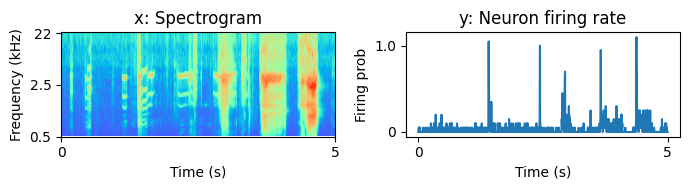

In [4]:
def plot(ax, xlabel, xticks, xticklabels, ylabel, yticks, yticklabels, title):
    ax.set_xlabel(xlabel)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_ylabel(ylabel)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_title(title)

x, y = test_dataset[0]
fig, ax = plt.subplots(1, 2, figsize=(7, 2))
ax[0].imshow(x, aspect="auto", cmap="rainbow")
ax[1].plot(y[0])
plot(ax[0], "Time (s)", [0, x.shape[1]], ["0", "5"], "Frequency (kHz)", [0, 32, 64], ["22", "2.5", "0.5"], "x: Spectrogram")
plot(ax[1], "Time (s)", [0, x.shape[1]], ["0", "5"], "Firing prob", [0, 1], ["0", "1.0"], "y: Neuron firing rate")
fig.tight_layout()

Plotted above is an example spectrogram representation of some sound (left) and the corresponding neural response from a single neuron to that sound (right). Left is input x to the model and right is the target y we try to predict.

### The ANN model

In [5]:
class ANN(devtorch.DevModel):
    
    def __init__(self, n_in, n_bins, n_hidden, n_out):
        super().__init__()
        self.n_in, self.n_bins, self.n_hidden, self.n_out = n_in, n_bins, n_hidden, n_out
        self.layer1 = torch.nn.Conv2d(1, n_hidden, (n_in, n_bins),  bias=True)
        self.layer2 = nn.Linear(n_hidden, n_out, bias=True)
        self.init_weight(self.layer1.weight, "glorot_uniform")
        self.init_weight(self.layer2.weight, "glorot_uniform")
        
    @property
    def hyperparams(self):
        return {**super().hyperparams, "n_in": self.n_in, "n_hidden": self.n_hidden, "n_out": self.n_out, "n_bins": self.n_bins}
    
    def get_params(self):
        return [self.layer1.weight, self.layer2.weight]
    
    def forward(self, x): 
        # x: b x n x t
        x = F.pad(x, (self.n_bins - 1, 0))
        x = self.layer1(x.unsqueeze(1))[:, :, 0]
        x = F.softplus(x, 10, 20)
        x = x.permute(0, 2, 1)  # -> b x t x n
        x = self.layer2(x)
        x = x.permute(0, 2, 1)  # -> b x n x t
        x = F.softplus(x, 10, 20)
        
        return x

In [6]:
ann = ANN(n_in=train_dataset.n_channels, n_bins=40, n_hidden=200, n_out=train_dataset.n_neurons)

### Training using k-fold validation

We use k-fold cross validation to find the best regulirization. Another option is to use the devtorch.SplitValidationTrainer which checks model performance on a single held-out validation set (instead of multiple validation sets).

In [7]:
class NeuralTrainer(devtorch.Trainer):
    
    def __init__(self, model, train_dataset, root, n_epochs, batch_size, lr, lam, device="cuda", id=None):        
        super().__init__(model, train_dataset, root, n_epochs, batch_size, lr, optimizer_func=torch.optim.Adam, loader_kwargs={"shuffle": True}, device=device, grad_clip_type=None, grad_clip_value=0, id=id)
        self._lam = lam
    
    @staticmethod
    def load_model(root, model_id):

        def model_loader(hyperparams):
            model_params = hyperparams["model"]
            del model_params["name"]
            del model_params["weights"]
            
            return ANN(**model_params)
        
        return devtorch.load_model(root, model_id, model_loader)
    
    @property
    def hyperparams(self):
        return {**super().hyperparams, "lam": self._lam}
    
    def loss(self, output, target, model):
        pred_loss = F.poisson_nll_loss(output, target, log_input=False, full=False, eps=1e-08, reduction="mean")
        
        # Compute reg loss
        reg_loss = 0
        for param in model.get_params():
            reg_loss += torch.norm(param, p=1)
        
        total_loss = pred_loss + self._lam * reg_loss
        
        return total_loss

In [8]:
def compute_cc(pred, target):
    pred = pred.permute(1, 0, 2).flatten(1, 2)
    target = target.permute(1, 0, 2).flatten(1, 2)
    
    exp_xy = (pred * target).mean(dim=1)
    exp_x = pred.mean(dim=1)
    exp_y = target.mean(dim=1)
    exp_x2 = (pred**2).mean(dim=1)
    exp_y2 = (target**2).mean(dim=1)
    cc = (exp_xy - exp_x * exp_y) / (
            (torch.sqrt(exp_x2 - exp_x**2)) * (torch.sqrt(exp_y2 - exp_y**2))
    )
    return cc.mean()

root = "../../data/crossval"

# This is where the magic happens. A simple way to run k-fold cross validation using PyTorch.
kfold_validator = devtorch.KFoldValidationTrainer(root,
        ann,
        train_dataset,
        NeuralTrainer,
        trainer_kwargs={"n_epochs": 1000, "batch_size": 16, "lr": 0.001},
        lambdas=[10**-4, 10**-4.5, 10**-5, 10**-5.5, 10**-6],
        k=4,  # We employ 4-fold validation
        minimise_score=False,  # We want to maximise the correlation coefficient validation function
        final_repeat=1,  # How many final models to train
        val_loss=compute_cc,  # We check the correlation coefficient between our predictions and neural responses
        val_batch_size=256,
        final_epochs=2000  # We train our final model with more epochs
                                                  
)

trainer_logger = logging.getLogger("trainer")
trainer_logger.setLevel(logging.WARNING)  # We disable the epoch logger prints to avoid clogging the notebook
kfold_validator.train()

INFO:crossval:Fitting for l1=0.0001...
INFO:crossval:Fitting for l1=3.1622776601683795e-05...
INFO:crossval:Fitting for l1=1e-05...
INFO:crossval:Fitting for l1=3.162277660168379e-06...
INFO:crossval:Fitting for l1=1e-06...
INFO:crossval:Fitting for best l1=1e-05...


### Inspecting model performance

In [19]:
# We load the final model. The final model i is indexed with models/i. As we used final_repeat=1 we only have a single model.
trained_ann = NeuralTrainer.load_model("../../data/crossval", "models/0")

# Print correlation coefficient
cc = devtorch.compute_metric(trained_ann, test_dataset, compute_cc, batch_size=4)
print(f"Model cc = {cc[0].mean()}")

Model cc = 0.5229328274726868


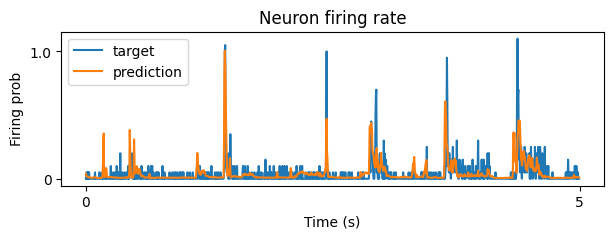

In [36]:
# We can plot the predicted neuron firing rate for a sample neuron from the test set
with torch.no_grad():
    ytar = trained_ann(test_dataset.x[0:1].cuda()).cpu()
    
n = 0
fig, ax = plt.subplots(1, 1, figsize=(7, 2))
ax.plot(test_dataset.y[0, n], label="target")
ax.plot(ytar[0, n], label="prediction")
plot(ax, "Time (s)", [0, x.shape[1]], ["0", "5"], "Firing prob", [0, 1], ["0", "1.0"], "Neuron firing rate")
ax.legend()

In [25]:
# We can load the table of train and val scores (correlation coefficient) and see the model obtains best performance
# when lam=1e-05
pd.read_csv(f"../../data/crossval/cv.csv")#["lam"].max()

,lam,train,val
0,0.000100,0.457054,0.435221
1,0.000032,0.507511,0.465197
2,0.000010,0.567918,0.485121
3,0.000003,0.606768,0.478321
4,0.000001,0.596203,0.443982


In [26]:
# For sanity we can check what lam the final model was trained with - et voila, the lamdba matches.
devtorch.load_hyperparams(f"../../data/crossval/models", "0")["lam"]

1e-05

**Exercise**: As an exercise, can you further tweak the model and training parameters to obtain better performance? Perhaps even develop a better model (as a side note, it is usually better to use the normalized correlation coefficient when benchmarking neuron response prediction as this takes into account neural noise).